In [1]:
from __future__ import print_function
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import time
import cv2
import argparse
import numpy as np

import torch
import torch.backends.cudnn as cudnn

from data import cfg_mnet, cfg_re50
from layers.functions.prior_box import PriorBox
from utils.nms.py_cpu_nms import py_cpu_nms
from utils.box_utils import decode, decode_landm
from models.retinaface import RetinaFace

In [2]:
trained_model='./weights/mobilenet0.25_Final.pth'  
network='mobile0.25'          #'resnet50'
cpu=False
confidence_threshold=0.02
top_k=5000
nms_threshold=0.4
keep_top_k=750
save_image=True
vis_thres=0.6


In [ ]:
def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True


def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}


def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

In [11]:
torch.set_grad_enabled(False)
cfg = None
if network == "mobile0.25":
    cfg = cfg_mnet
elif network == "resnet50":
    cfg = cfg_re50
# net and model
net = RetinaFace(cfg=cfg, phase = 'test')
net = load_model(net, trained_model, cpu)
net.eval()
print('Finished loading model!')
print(net)
cudnn.benchmark = True
device = torch.device("cpu" if cpu else "cuda")
net = net.to(device)

resize = 1

# testing begin
#     for i in range(100):
#     image_path = "./curve/test.jpg"
image_path = '/Data/jing/face/facebank/zw/ia_500002427.jpg'
img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)

img = np.float32(img_raw)

im_height, im_width, _ = img.shape
scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
img -= (104, 117, 123)
img = img.transpose(2, 0, 1)
img = torch.from_numpy(img).unsqueeze(0)
img = img.to(device)
scale = scale.to(device)

tic = time.time()
loc, conf, landms = net(img)  # forward pass
print('net forward time: {:.4f}'.format(time.time() - tic))

priorbox = PriorBox(cfg, image_size=(im_height, im_width))
priors = priorbox.forward()
priors = priors.to(device)
prior_data = priors.data
boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
boxes = boxes * scale / resize
boxes = boxes.cpu().numpy()
scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                       img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                       img.shape[3], img.shape[2]])
scale1 = scale1.to(device)
landms = landms * scale1 / resize
landms = landms.cpu().numpy()

# ignore low scores
inds = np.where(scores > confidence_threshold)[0]
boxes = boxes[inds]
landms = landms[inds]
scores = scores[inds]

# keep top-K before NMS
order = scores.argsort()[::-1][:top_k]
boxes = boxes[order]
landms = landms[order]
scores = scores[order]

# do NMS
dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
keep = py_cpu_nms(dets, nms_threshold)
# keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
dets = dets[keep, :]
landms = landms[keep]

# keep top-K faster NMS
dets = dets[:keep_top_k, :]
landms = landms[:keep_top_k, :]

dets = np.concatenate((dets, landms), axis=1)

# show image
if save_image:
    for b in dets:
        if b[4] < vis_thres:
            continue
        text = "{:.4f}".format(b[4])
        b = list(map(int, b))
        cv2.rectangle(img_raw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
        cx = b[0]
        cy = b[1] + 12
        cv2.putText(img_raw, text, (cx, cy),
                    cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

        # landms
        cv2.circle(img_raw, (b[5], b[6]), 1, (0, 0, 255), 4)
        cv2.circle(img_raw, (b[7], b[8]), 1, (0, 255, 255), 4)
        cv2.circle(img_raw, (b[9], b[10]), 1, (255, 0, 255), 4)
        cv2.circle(img_raw, (b[11], b[12]), 1, (0, 255, 0), 4)
        cv2.circle(img_raw, (b[13], b[14]), 1, (255, 0, 0), 4)
    # save image

    name = "test.jpg"
    cv2.imwrite(name, img_raw)

Loading pretrained model from ./weights/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300
Finished loading model!
RetinaFace(
  (body): IntermediateLayerGetter(
    (stage1): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.1, inplace=Tru

net forward time: 0.2765


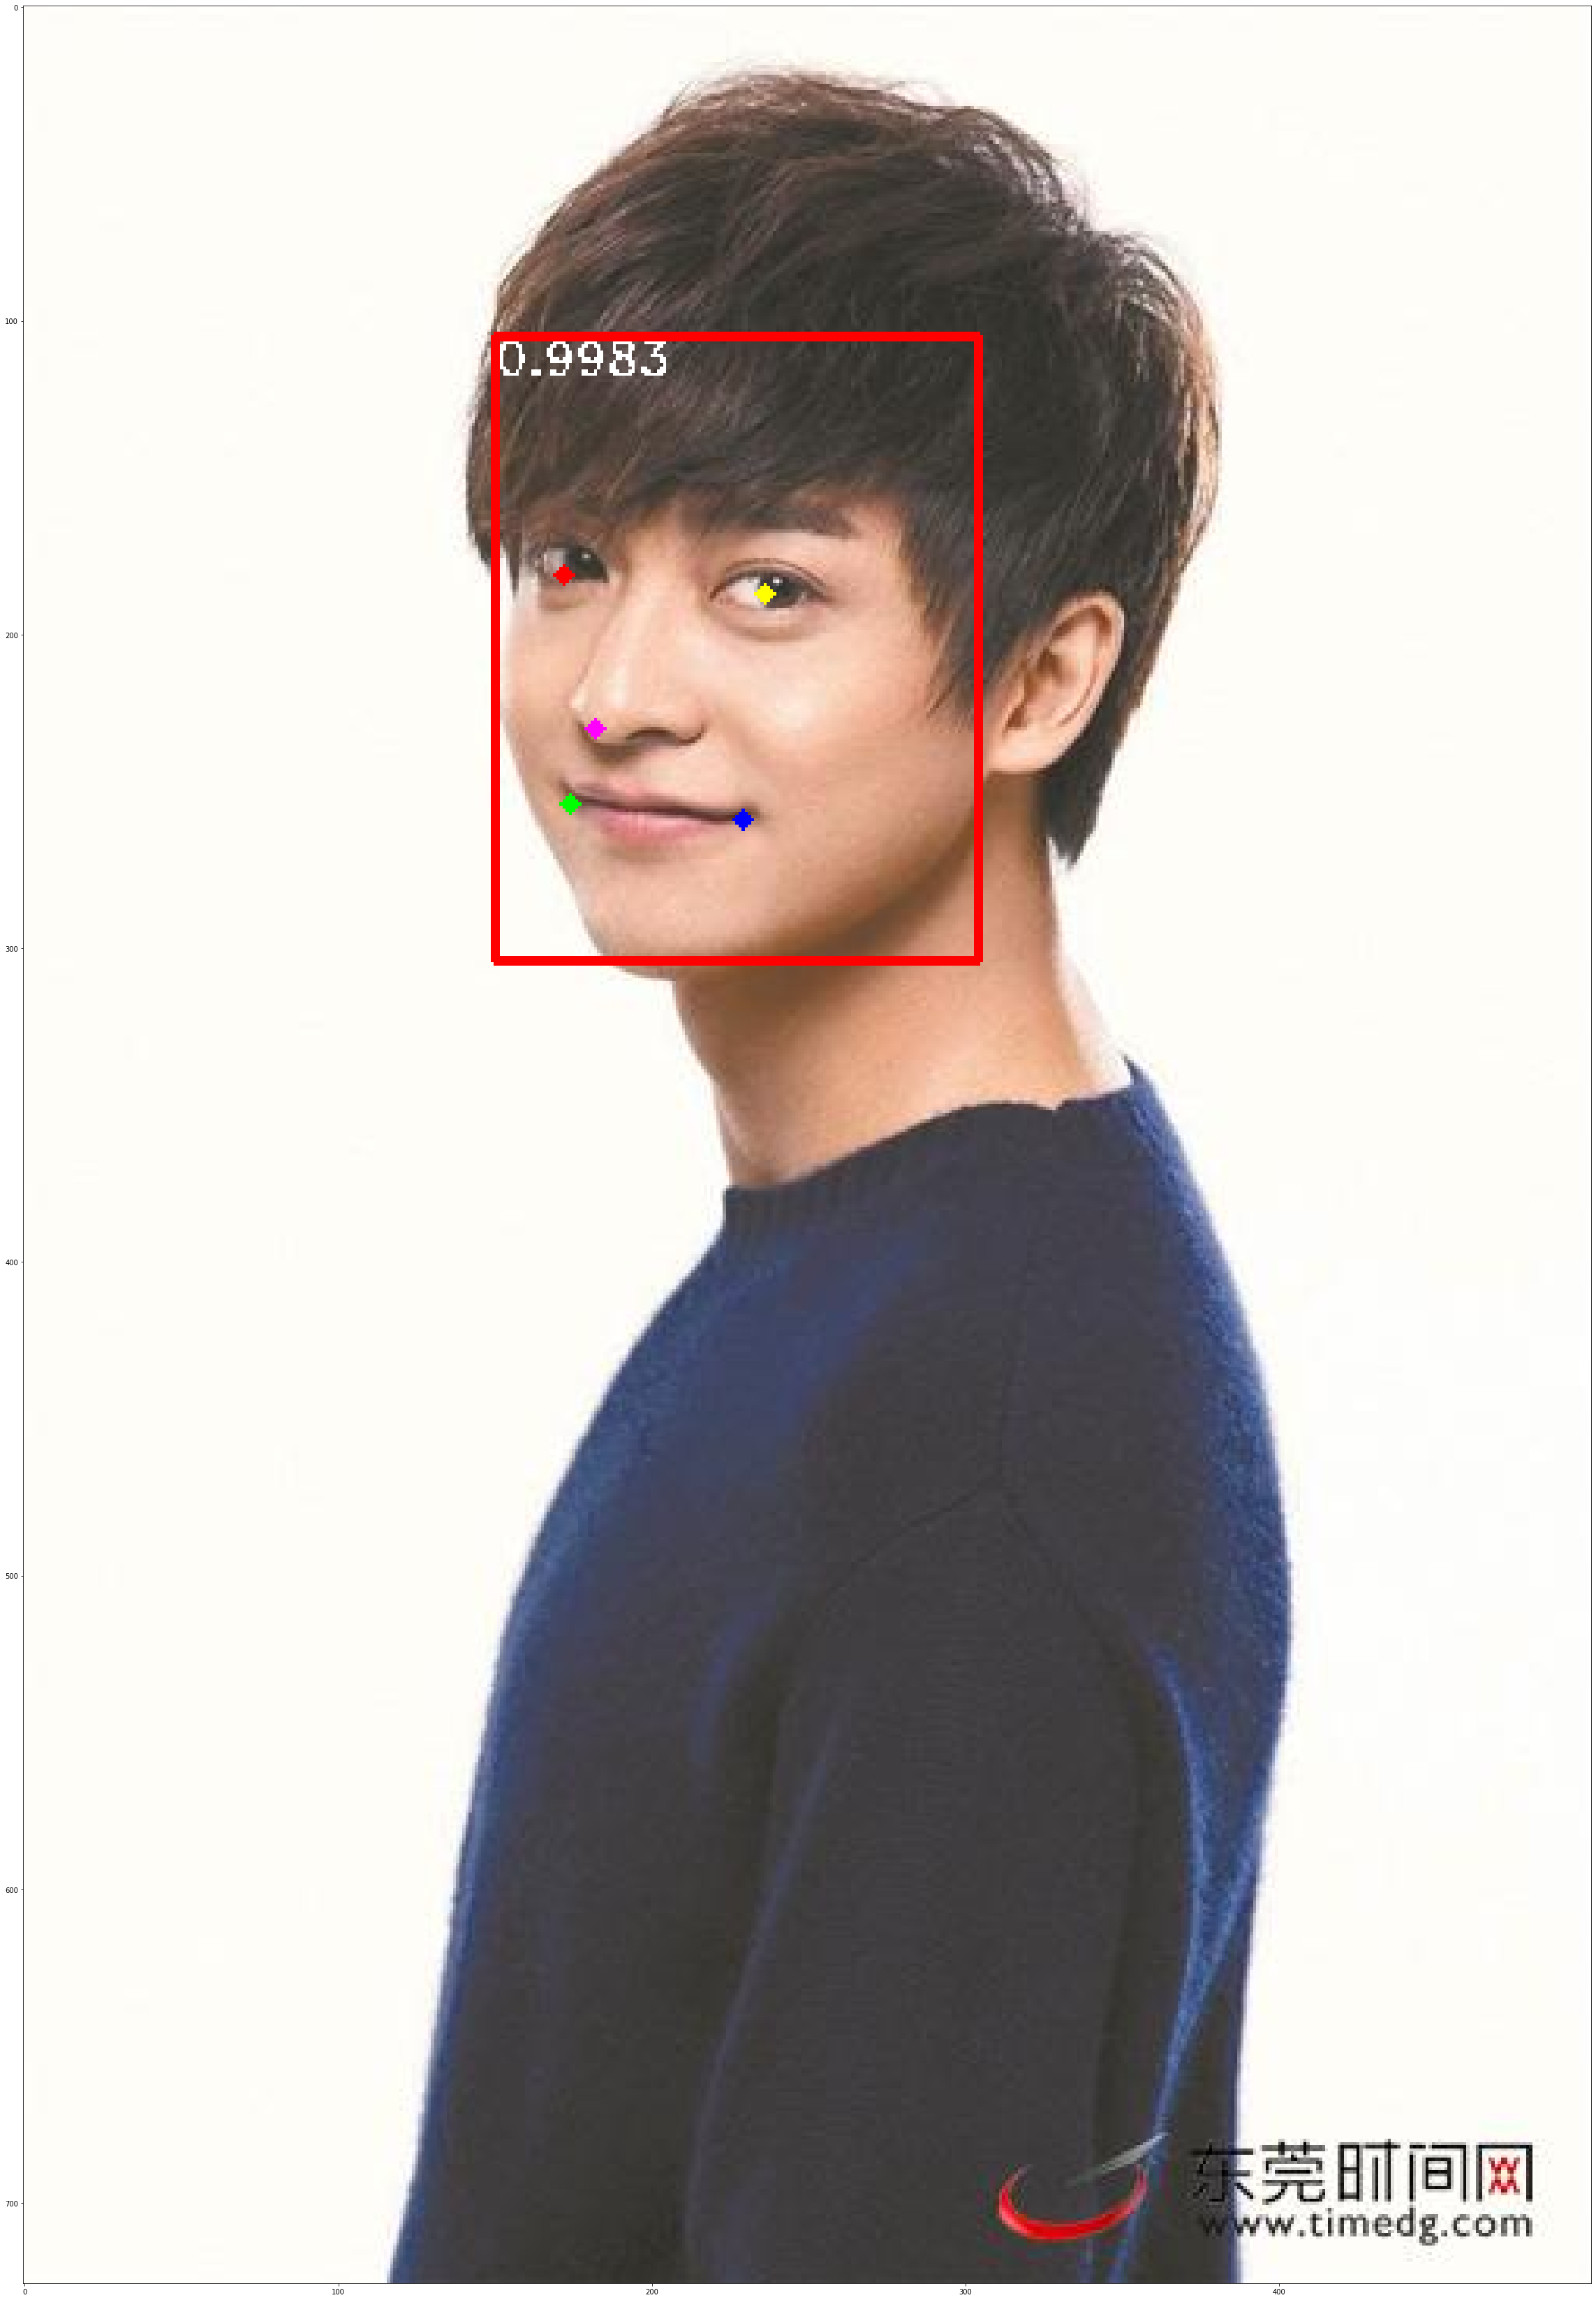

In [12]:
from matplotlib import pyplot as plt
# resnet50检测显示
plt.figure(figsize=(60,60))
plt.imshow(img_raw[:,:,[2,1,0]])
plt.show()  

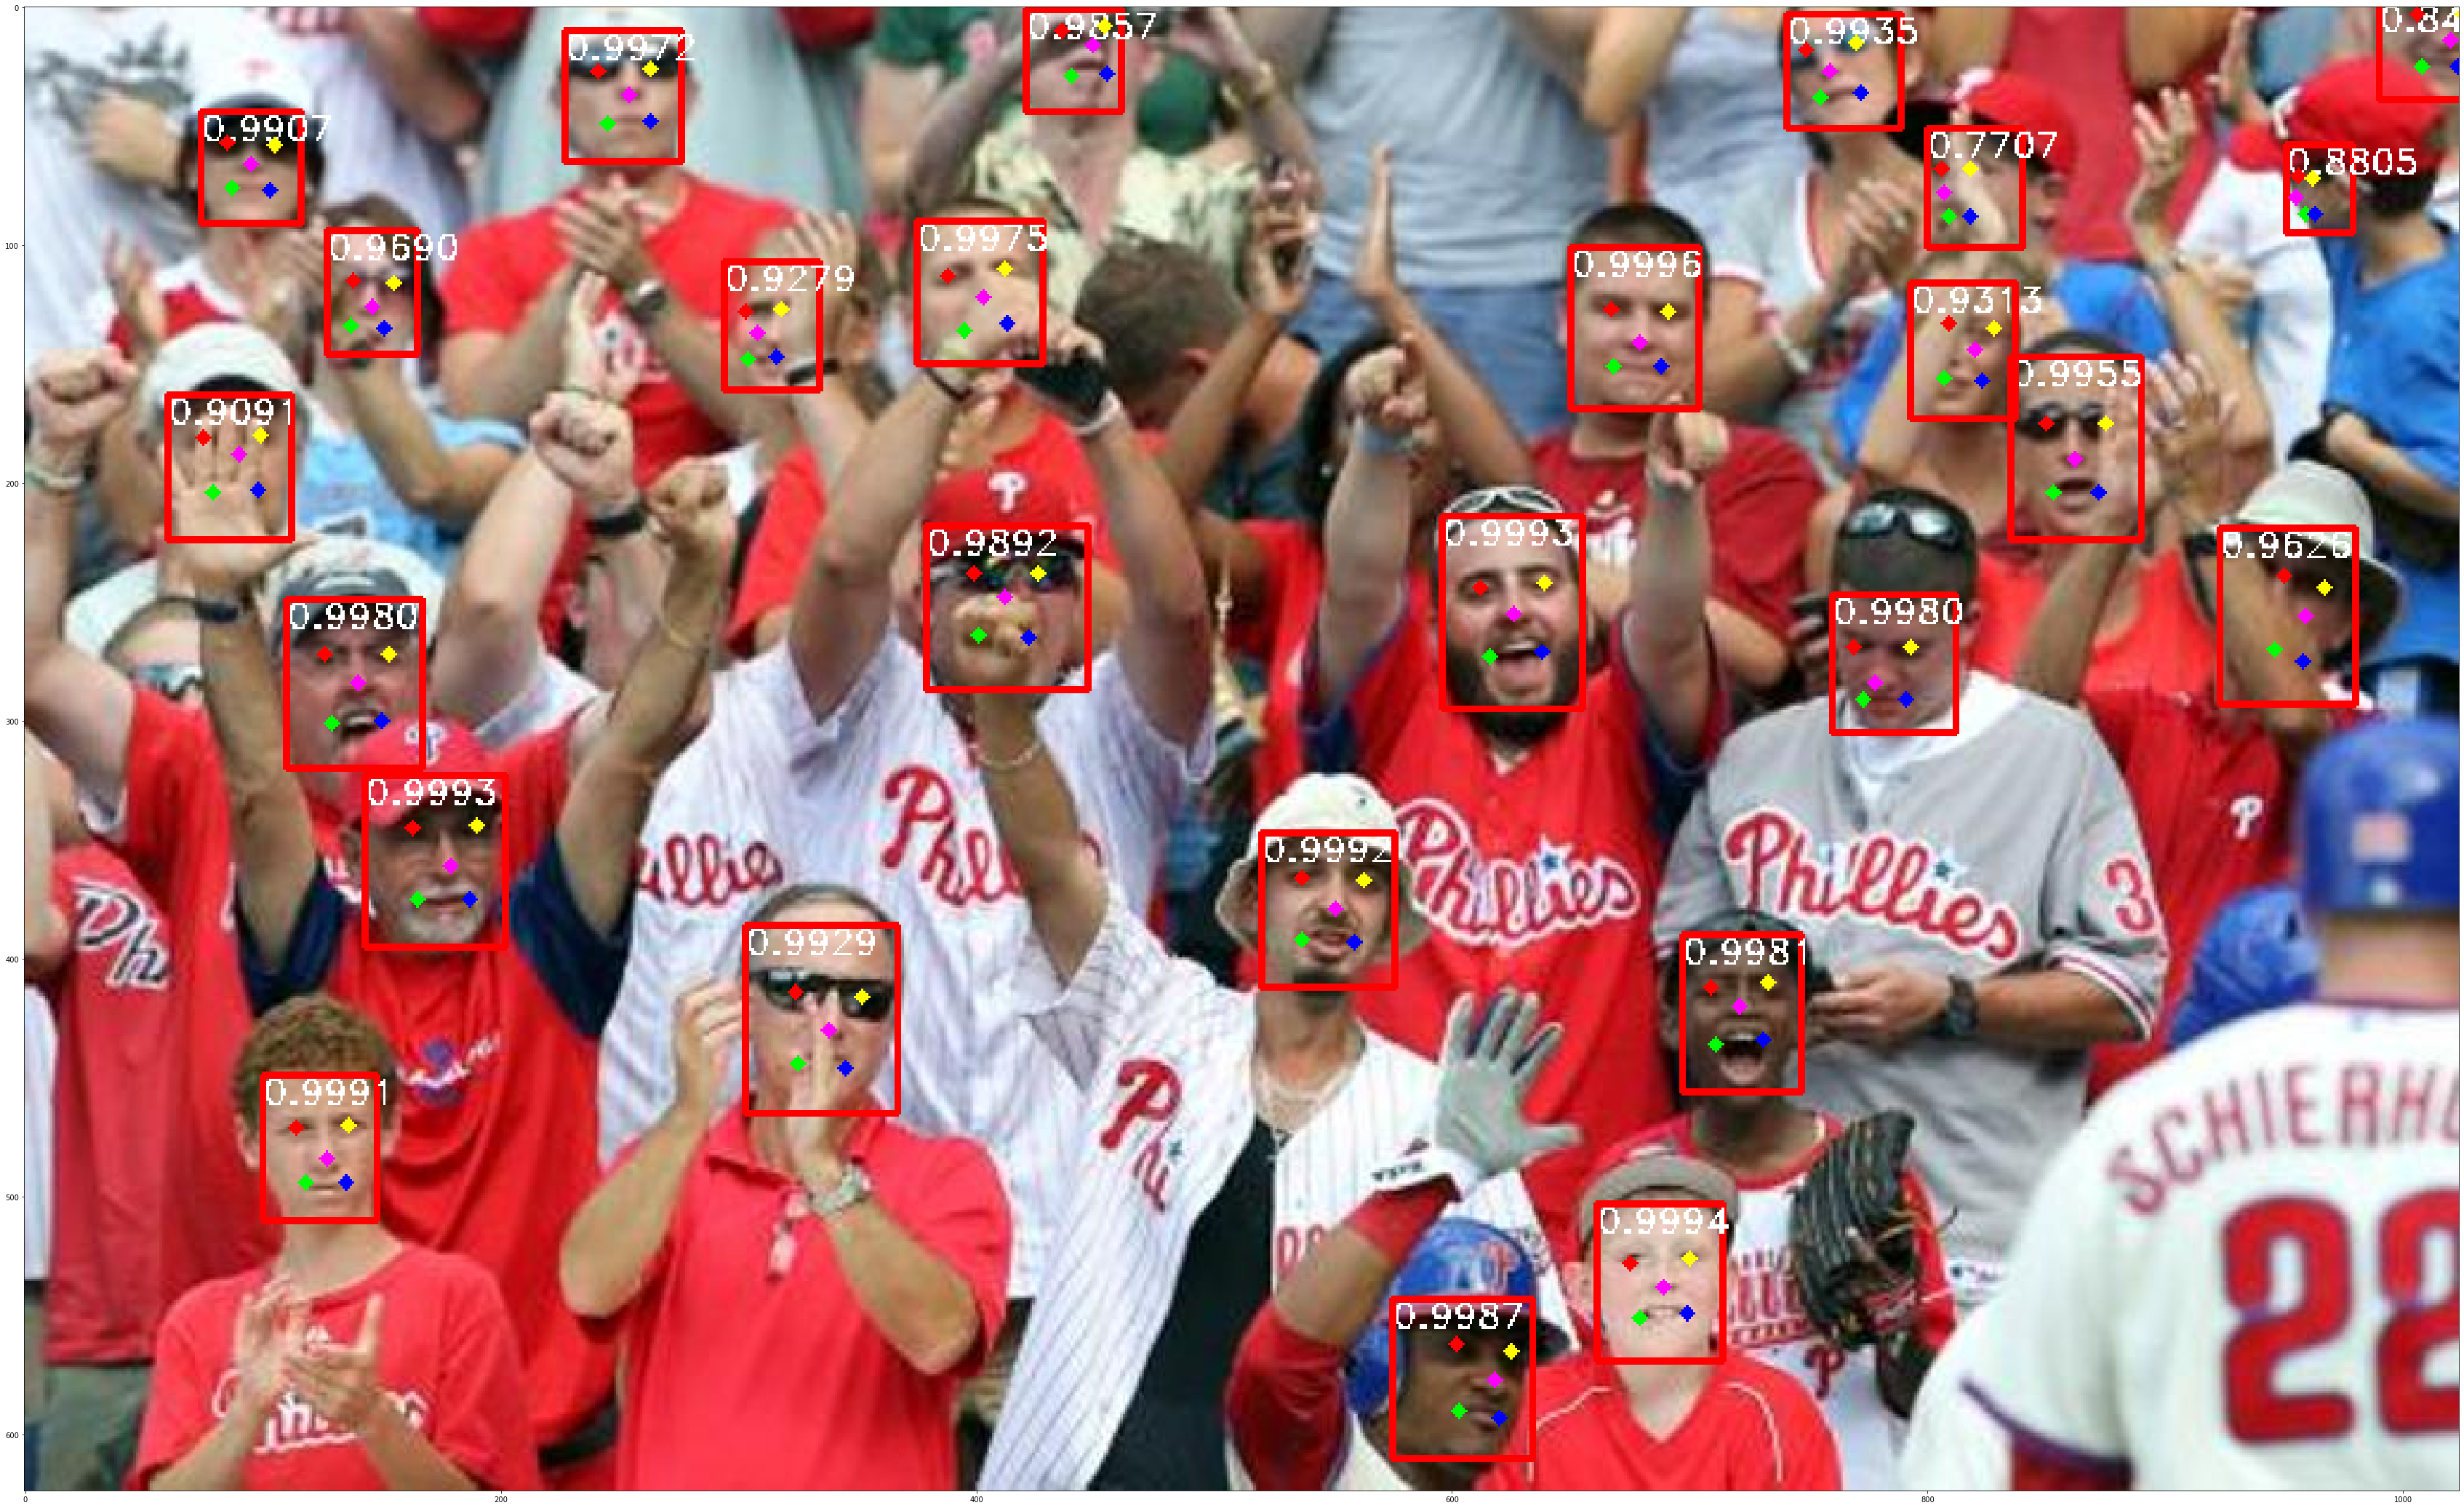

In [12]:
# mobilenet检测显示
plt.figure(figsize=(60,60))
plt.imshow(img_raw[:,:,[2,1,0]])
plt.show() 